In [1]:
## Installing the dependencies (might take some time)

!pip install -q pytesseract
!sudo apt install  -q tesseract-ocr
!pip install  -q transformers
!pip install  -q pytorch-lightning
!pip install  -q einops
!pip install  -q tqdm
!pip install  -q 'Pillow==7.1.2'
!pip install -q wandb
!pip install -q torchmetrics
!pip install -q gdown

Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 74 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pytesseract 0.3.10 requires Pillow>=8.0.0, but you have pillow 7.1.2 which is incompatible.
imageio 2.19.3 requires pillow>=8.3.2, but you have pillow 7.1.2 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.


In [2]:
## Cloning the repository
!git clone https://github.com/uakarsh/LiLT.git

Cloning into 'LiLT'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 73 (delta 30), reused 35 (delta 6), pack-reused 0
Unpacking objects: 100% (73/73), 8.00 MiB | 7.80 MiB/s, done.


In [3]:
## Logging into wandb

import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import gdown
url = 'https://drive.google.com/uc?id=1eRV4fS_LFwI5MHqcRwLUNQZgewxI6Se_'
output = 'lilt_ckpt.ckpt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1eRV4fS_LFwI5MHqcRwLUNQZgewxI6Se_
To: /kaggle/working/lilt_ckpt.ckpt
100%|██████████| 2.53G/2.53G [00:41<00:00, 60.5MB/s]


'lilt_ckpt.ckpt'

In [5]:
import pandas as pd
import os
from PIL import Image, ImageDraw
from transformers import RobertaTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl

## Adding the path of lilt to system path
import sys
sys.path.append('./LiLT/src/lilt/')

from dataset import create_features
from modeling import LiLT

In [6]:
## Hyperparameters
seed = 42

## One can change this configuration and try out new combination
config = {
  "hidden_dropout_prob": 0.1,
  "hidden_size_t": 768,
  "hidden_size" : 768,
  "hidden_size_l": 768 // 6,
  "intermediate_ff_size_factor": 4,
  "max_2d_position_embeddings": 1001,
  "max_seq_len_l": 512,
  "max_seq_len_t" : 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  'dim_head' : 64,
  "shape_size": 96,
  "vocab_size": 50265,
  "eps": 1e-12,
  "fine_tune" : True
}

id2label = ['scientific_report',
 'resume',
 'memo',
 'file_folder',
 'specification',
 'news_article',
 'letter',
 'form',
 'budget',
 'handwritten',
 'email',
 'invoice',
 'presentation',
 'scientific_publication',
 'questionnaire',
 'advertisement']

## A Small set of data for training and testing LiLT

In [7]:
from tqdm.auto import tqdm

## For the purpose of prediction
id2label = []
label2id = {}

curr_class = 0
## Preparing the Dataset
base_directory = '../input/the-rvlcdip-dataset-test/test'
dict_of_img_labels = {'img':[], 'label':[]}

max_sample_per_class = 250

for label in tqdm(os.listdir(base_directory)):
    img_path = os.path.join(base_directory, label)
    
    count = 0
    if label not in label2id:
        label2id[label] = curr_class
        curr_class+=1
        id2label.append(label)
        
    for img in os.listdir(img_path):
        if count>max_sample_per_class:
            break
            
        curr_img_path = os.path.join(img_path, img)
        dict_of_img_labels['img'].append(curr_img_path)
        dict_of_img_labels['label'].append(label2id[label])
        count+=1

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
import pandas as pd
df = pd.DataFrame(dict_of_img_labels)

In [9]:
from sklearn.model_selection import train_test_split as tts
train_df, valid_df = tts(df, random_state = seed, stratify = df['label'], shuffle = True)
train_df = train_df.reset_index().drop(columns = ['index'], axis = 1)
valid_df = valid_df.reset_index().drop(columns = ['index'], axis = 1)

In [10]:
## Creating the dataset

class RVLCDIPData(Dataset):
    
    def __init__(self, image_list, label_list, tokenizer, max_len = 512, size = 1000):
        
        self.image_list = image_list
        self.label_list = label_list
        self.tokenizer = tokenizer
        self.max_seq_length = max_len
        self.size = size
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        label = self.label_list[idx]
        
        boxes, words, normal_box = create_features(
                                img_path = img_path,
                                tokenizer = self.tokenizer,
                                max_seq_length = self.max_seq_length,
                                size = self.size,
                                use_ocr  = True,
                               )
        
        final_encoding = {'input_boxes': boxes, 'input_words': words, 'actual_boxes': normal_box}
        final_encoding['label'] = torch.as_tensor(label).long()
        
        return final_encoding

In [11]:
## Defining tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

## Defining the dataset
train_ds = RVLCDIPData(train_df['img'].tolist(), train_df['label'].tolist(),
                      tokenizer, config['max_seq_len_l'])
val_ds = RVLCDIPData(valid_df['img'].tolist(), valid_df['label'].tolist(),
                      tokenizer,config['max_seq_len_l'])

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
def collate_fn(list_of_ds):
  encoding = {'input_boxes' : [], 'input_words' : [],'label' : []}

  for i in list_of_ds:
    for key in encoding.keys():
      encoding[key].append(i[key])
    
  for key in encoding.keys():
    encoding[key] = torch.stack(encoding[key], axis = 0)
    
  return encoding

## Defining the data module

In [13]:
class DataModule(pl.LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  batch_size = 1):

    super(DataModule, self).__init__()
    self.save_hyperparameters()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size | self.hparams.batch_size, 
                      collate_fn = collate_fn, shuffle = True, num_workers = 2)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size | self.hparams.batch_size,
                                  collate_fn = collate_fn, shuffle = False, num_workers = 2)

In [14]:
class LiLTForClassification(nn.Module):
  
    def __init__(self, config):
      super(LiLTForClassification, self).__init__()

      self.lilt = LiLT(config)
      self.config = config
      self.dropout = nn.Dropout(config['hidden_dropout_prob'])
      self.linear_layer = nn.Linear(in_features = config['hidden_size'] * 2, out_features = len(id2label))  ## Number of Classes

    def forward(self, batch_dict):
        encodings = self.lilt(batch_dict['input_words'], batch_dict['input_boxes'])
        final_out = torch.cat([encodings['layout_hidden_states'][-1], 
                              encodings['text_hidden_states'][-1]
                              ],
                             axis = -1)[:, 0, :]
        final_out = self.linear_layer(final_out)
        return final_out

In [15]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# lilt = LiLTForClassification(config).to(device)
# datamodule = DataModule(train_ds, val_ds)

# sample = next(iter(datamodule.train_dataloader()))
# encoding = lilt(sample)

In [16]:
## Defining pytorch lightning model
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchmetrics

class LiLTPL(pl.LightningModule):

  def __init__(self, config , lr = 5e-5):
    super(LiLTPL, self).__init__()
    
    self.save_hyperparameters()
    self.config = config
    self.lilt = LiLTForClassification(config)
    
    self.num_classes = len(id2label)
    self.train_accuracy_metric = torchmetrics.Accuracy()
    self.val_accuracy_metric = torchmetrics.Accuracy()
    self.f1_metric = torchmetrics.F1Score(num_classes=self.num_classes)
    self.precision_macro_metric = torchmetrics.Precision(
            average="macro", num_classes=self.num_classes
        )
    self.recall_macro_metric = torchmetrics.Recall(
            average="macro", num_classes=self.num_classes
        )
    self.precision_micro_metric = torchmetrics.Precision(average="micro")
    self.recall_micro_metric = torchmetrics.Recall(average="micro")

  def forward(self, batch_dict):
    logits = self.lilt(batch_dict)
    return logits

  def training_step(self, batch, batch_idx):
    logits = self.forward(batch)

    loss = nn.CrossEntropyLoss()(logits, batch['label'])
    preds = torch.argmax(logits, 1)

    ## Calculating the accuracy score
    train_acc = self.train_accuracy_metric(preds, batch["label"])

    ## Logging
    self.log('train/loss', loss,prog_bar = True, on_epoch=True, logger=True, on_step=True)
    self.log('train/acc', train_acc, prog_bar = True, on_epoch=True, logger=True, on_step=True)

    return loss
  
  def validation_step(self, batch, batch_idx):
    logits = self.forward(batch)
    loss = nn.CrossEntropyLoss()(logits, batch['label'])
    preds = torch.argmax(logits, 1)
    
    labels = batch['label']
    # Metrics
    valid_acc = self.val_accuracy_metric(preds, labels)
    precision_macro = self.precision_macro_metric(preds, labels)
    recall_macro = self.recall_macro_metric(preds, labels)
    precision_micro = self.precision_micro_metric(preds, labels)
    recall_micro = self.recall_micro_metric(preds, labels)
    f1 = self.f1_metric(preds, labels)

    # Logging metrics
    self.log("valid/loss", loss, prog_bar=True, on_step=True, logger=True)
    self.log("valid/acc", valid_acc, prog_bar=True, on_epoch=True, logger=True, on_step=True)
    self.log("valid/precision_macro", precision_macro, prog_bar=True, on_epoch=True, logger=True, on_step=True)
    self.log("valid/recall_macro", recall_macro, prog_bar=True, on_epoch=True, logger=True, on_step=True)
    self.log("valid/precision_micro", precision_micro, prog_bar=True, on_epoch=True, logger=True, on_step=True)
    self.log("valid/recall_micro", recall_micro, prog_bar=True, on_epoch=True, logger=True, on_step=True)
    self.log("valid/f1", f1, prog_bar=True, on_epoch=True)
    
    return {"label": batch['label'], "logits": logits}

  def validation_epoch_end(self, outputs):
        labels = torch.cat([x["label"] for x in outputs])
        logits = torch.cat([x["logits"] for x in outputs])
        preds = torch.argmax(logits, 1)

        wandb.log({"cm": wandb.sklearn.plot_confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())})
        self.logger.experiment.log(
            {"roc": wandb.plot.roc_curve(labels.cpu().numpy(), logits.cpu().numpy())}
        )
        
  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr = self.hparams['lr'])

In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

def main():
    lilt_pl = LiLTPL(config)
    lilt_pl = lilt_pl.load_from_checkpoint('./lilt_ckpt.ckpt')
    return lilt_pl

In [18]:
lilt = main()

In [19]:
## Utility function for plotting the OCR detected on the document

def plot_ocr_on_image(img, bounding_box):
  draw = ImageDraw.Draw(img)  
  
  for curr_box in bounding_box:
    curr_box = tuple(curr_box)
    x0, x1, y0, y1, width, height = curr_box
    draw.rectangle(xy = [(x0, y0), (x1, y1)], outline = 'purple')
  
  return img

## Visualizing the Bounding box OCRs

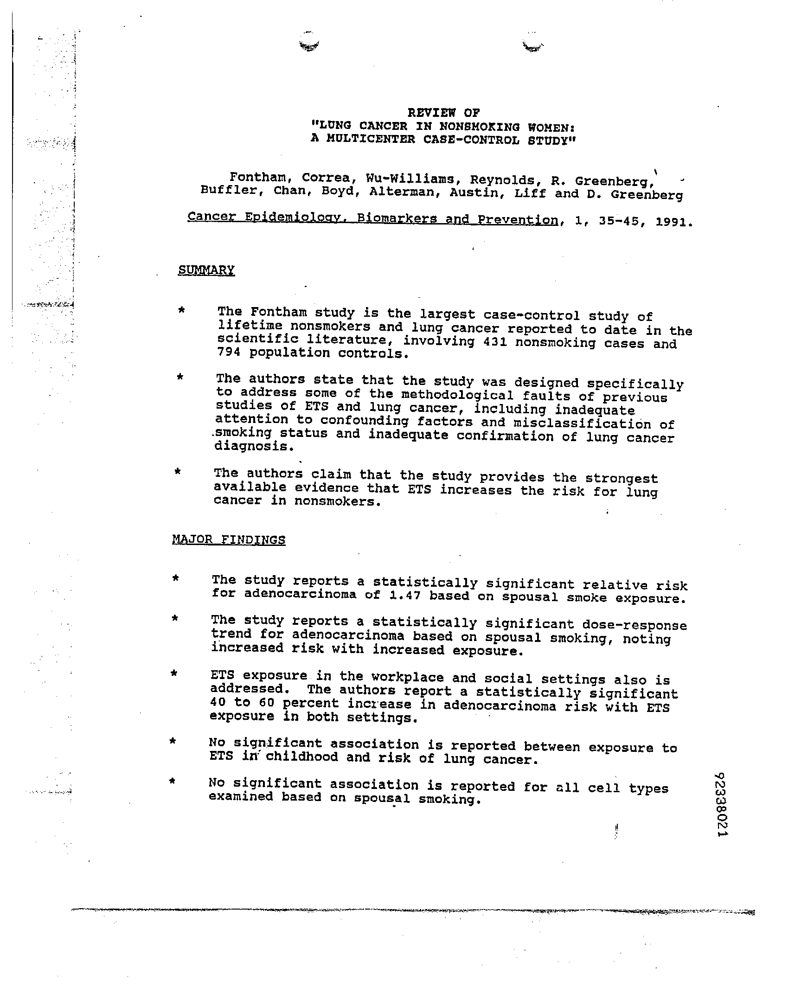

In [20]:
## Sanity Checking
idx = 1
sample_encoding = train_ds[idx]

sample_tif_path = train_df['img'].tolist()[idx]
image = Image.open(sample_tif_path).convert("RGB")

image.save("normal_img.png")
image

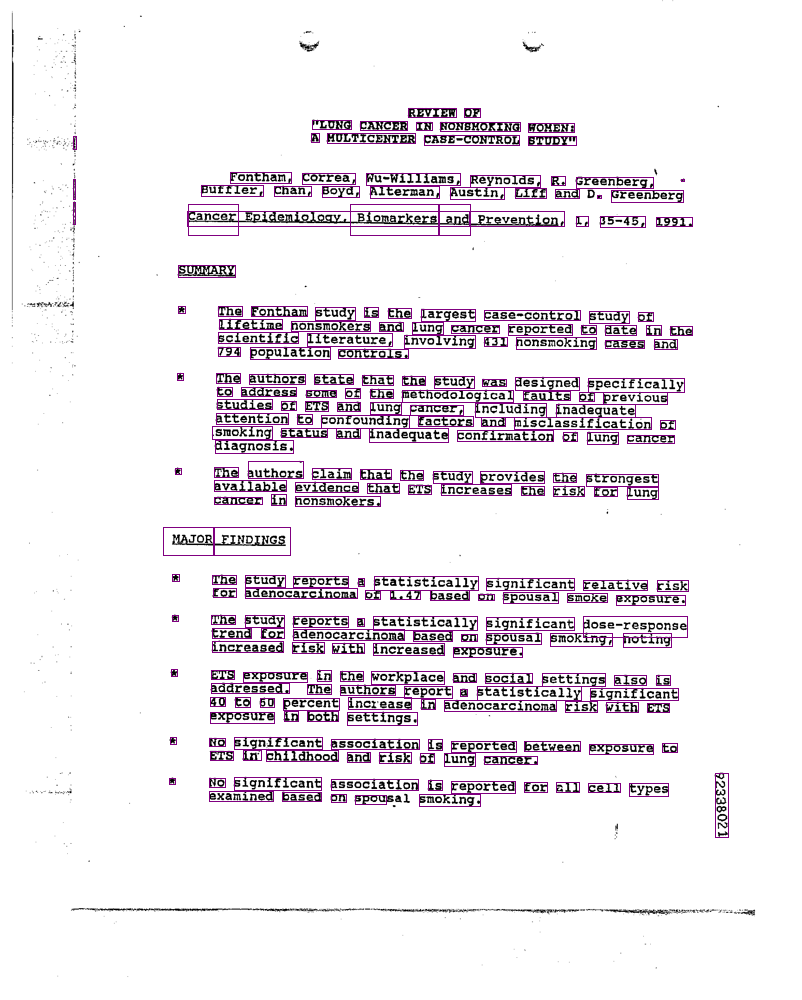

In [21]:
image = plot_ocr_on_image(image, sample_encoding['actual_boxes'])
image.save("bbox_img.png")
image

## Visualizing the Attentions

In [22]:
sample_encoding['input_words'] = sample_encoding['input_words'].unsqueeze(0)
sample_encoding['input_boxes'] = sample_encoding['input_boxes'].unsqueeze(0)

In [23]:
encoding = lilt.lilt.lilt(sample_encoding['input_words'], sample_encoding['input_boxes'])

In [24]:
prediction = id2label[lilt.lilt(sample_encoding).argmax().item()]

In [25]:
textual_attn_first_state = encoding['text_attn'][0][:, 0, :, :]
layout_attn_first_state = encoding['layout_attn'][0][:, 0, :, :]

In [26]:
layout_attn_first_state_prob = nn.Softmax(dim = -1)(layout_attn_first_state)
textual_attn_first_state_prob = nn.Softmax(dim = -1)(textual_attn_first_state)

In [27]:
import seaborn as sns

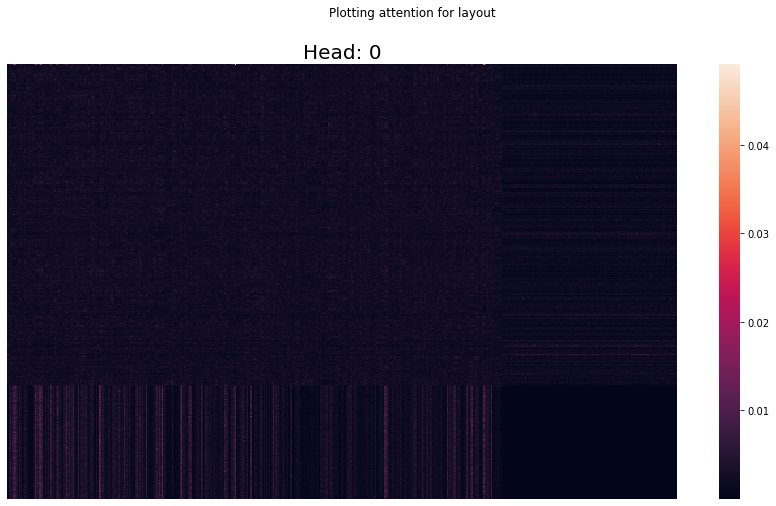

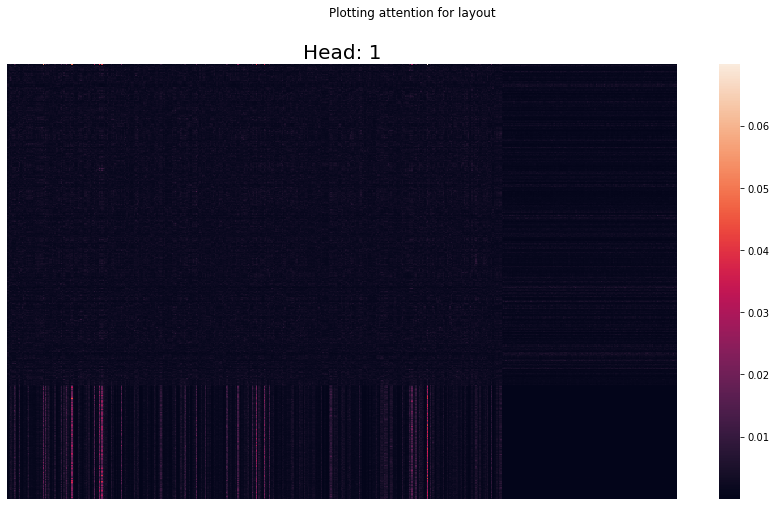

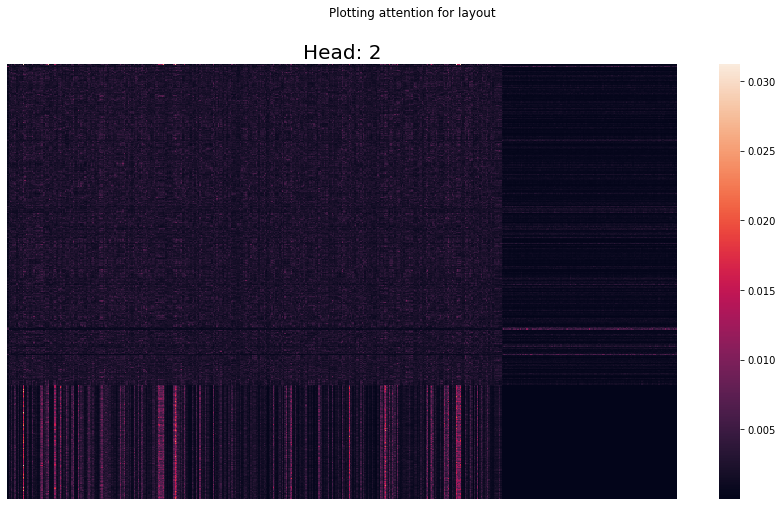

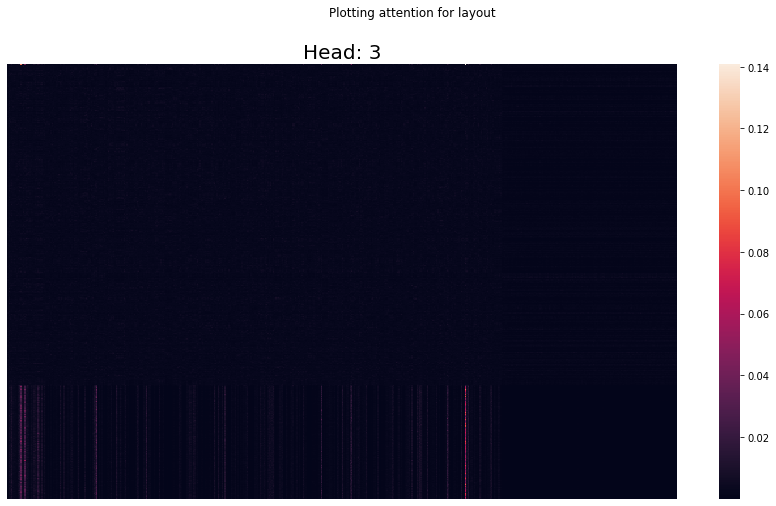

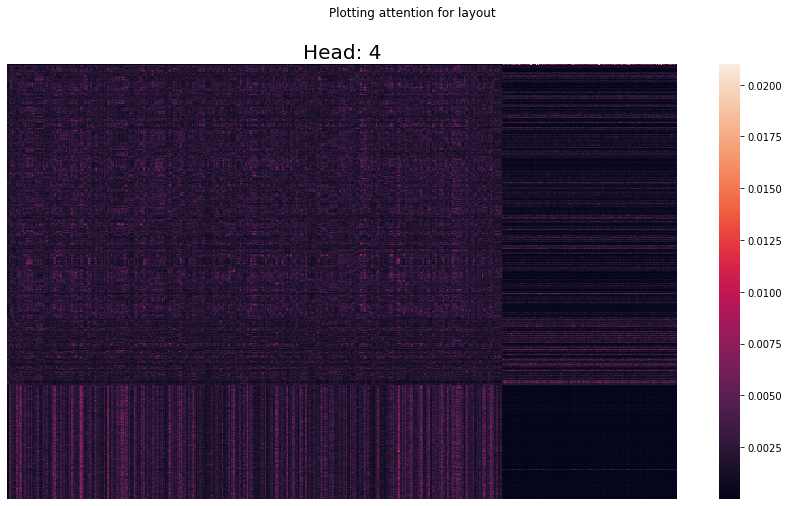

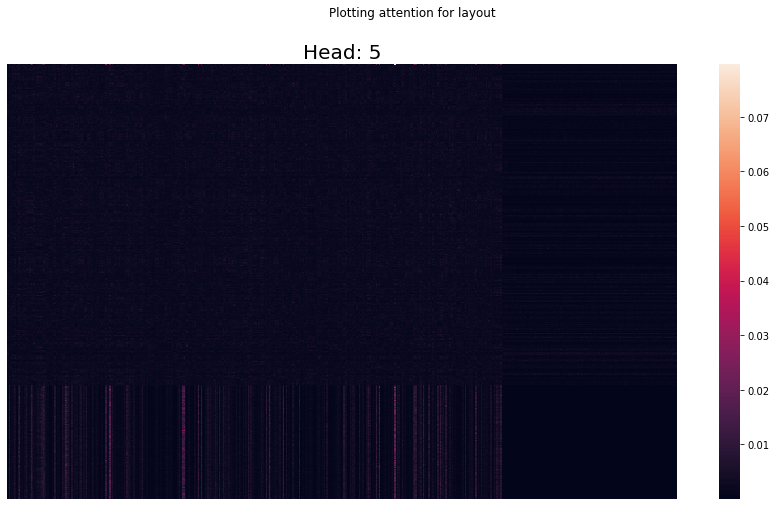

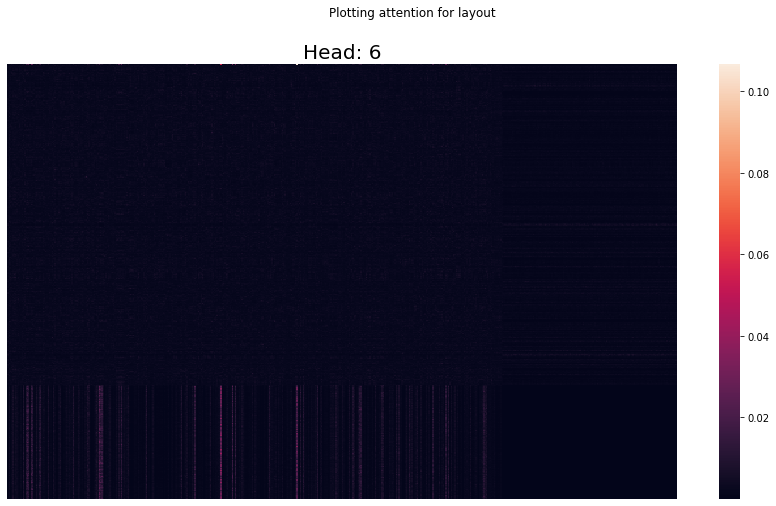

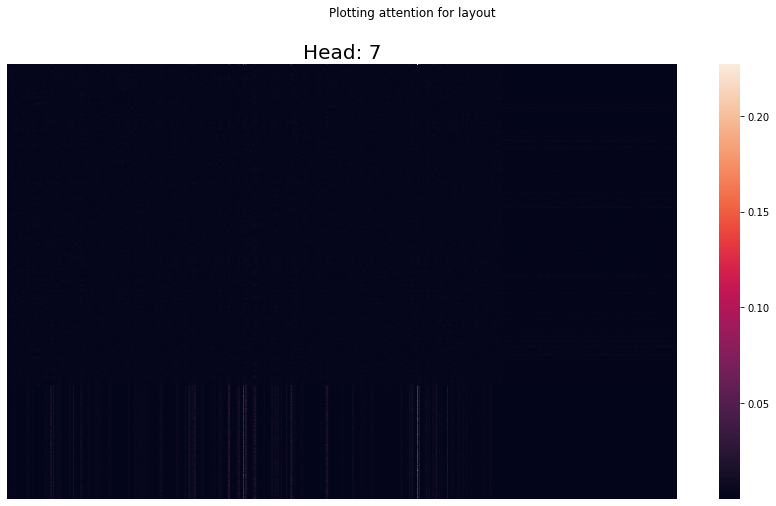

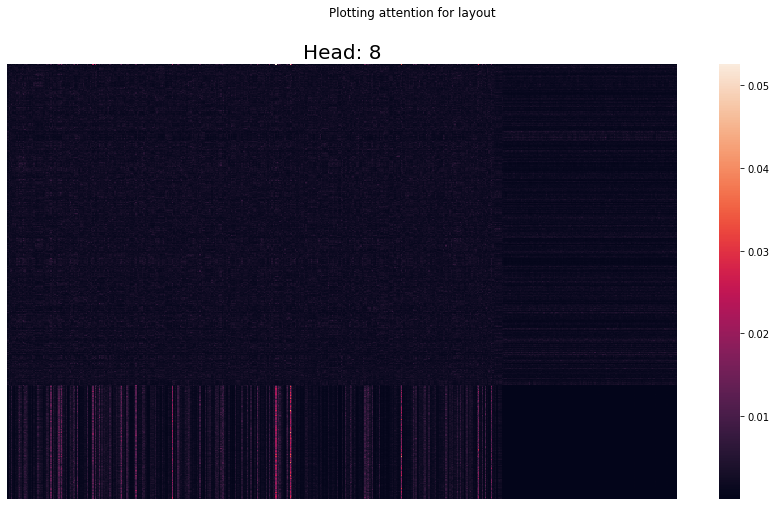

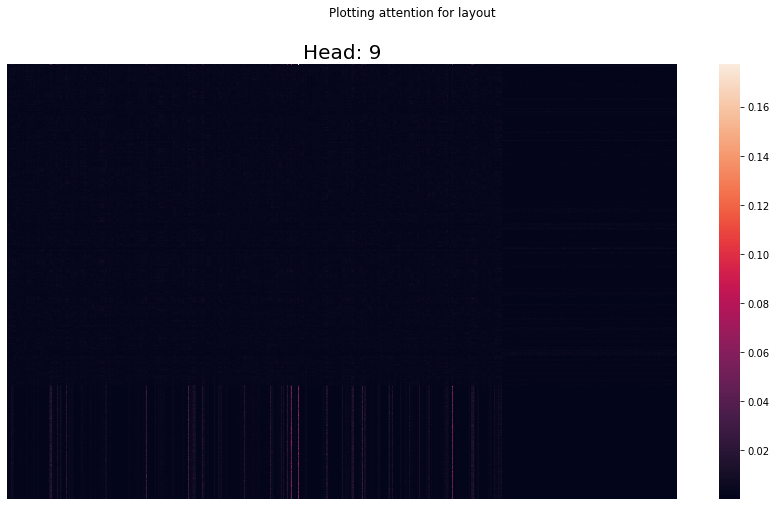

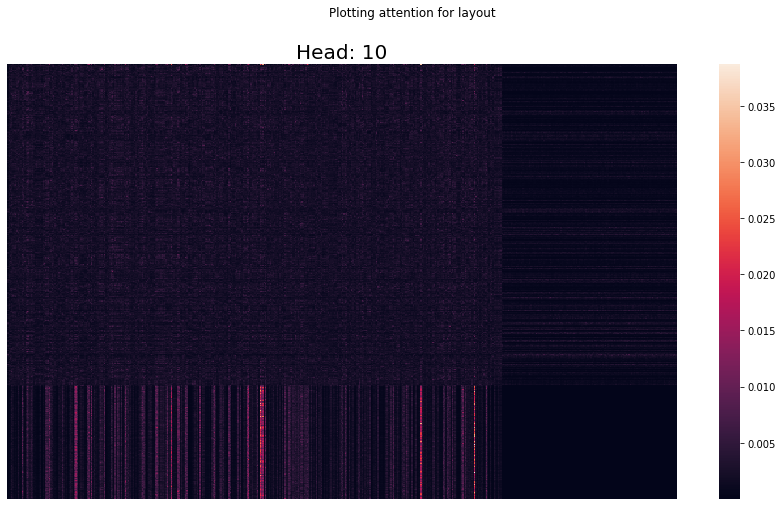

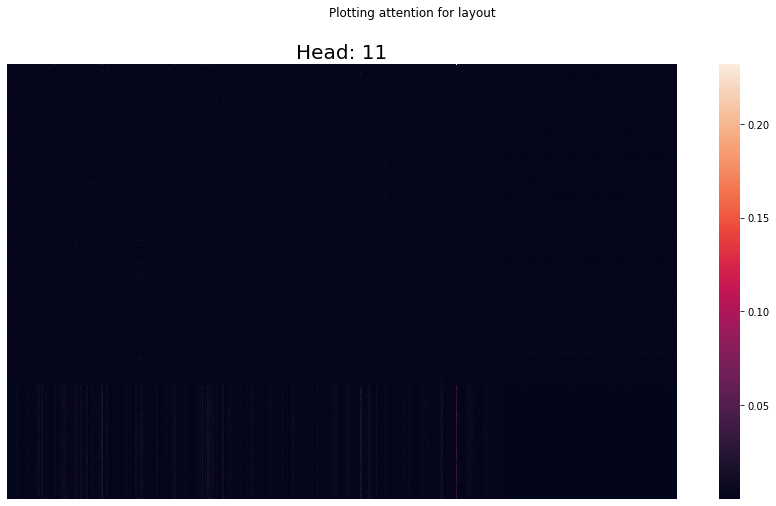

In [28]:
## Plotting the attentions, firstly for layout
heads = layout_attn_first_state_prob.shape[0]
for head in range(heads):
    plt.figure(figsize = (15, 8))
    sns.heatmap(layout_attn_first_state_prob[head].detach().numpy(), yticklabels=False, xticklabels=False);
    plt.title(f"Head: {head}", fontsize =20)
    plt.suptitle("Plotting attention for layout")

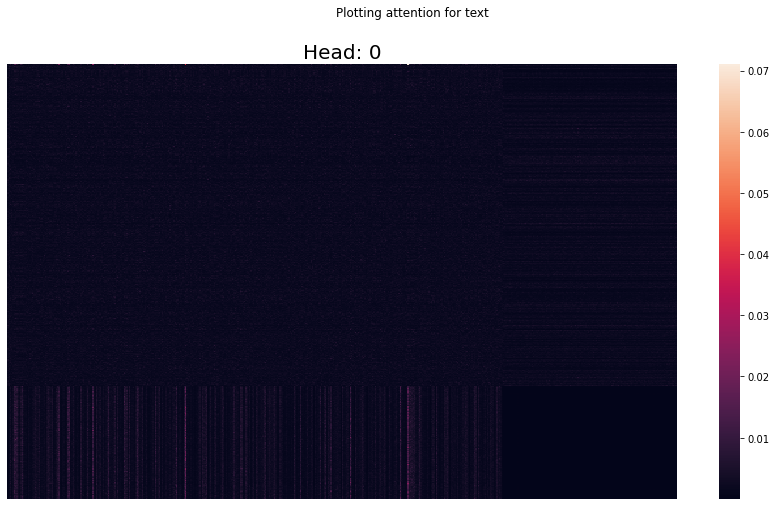

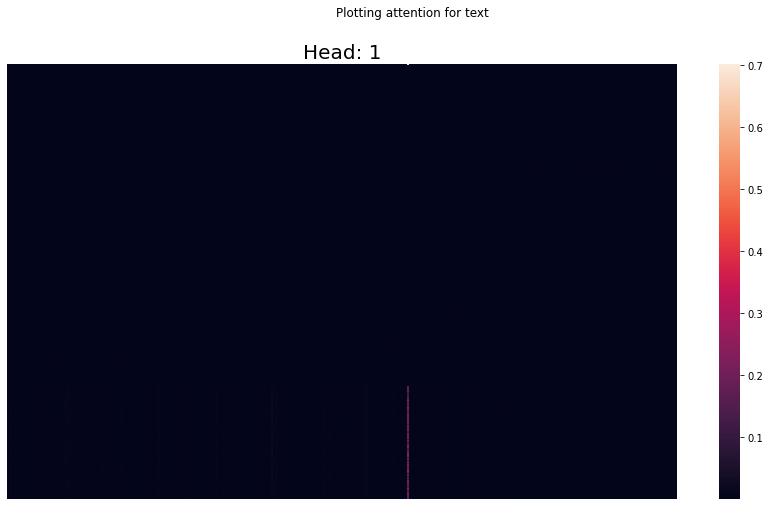

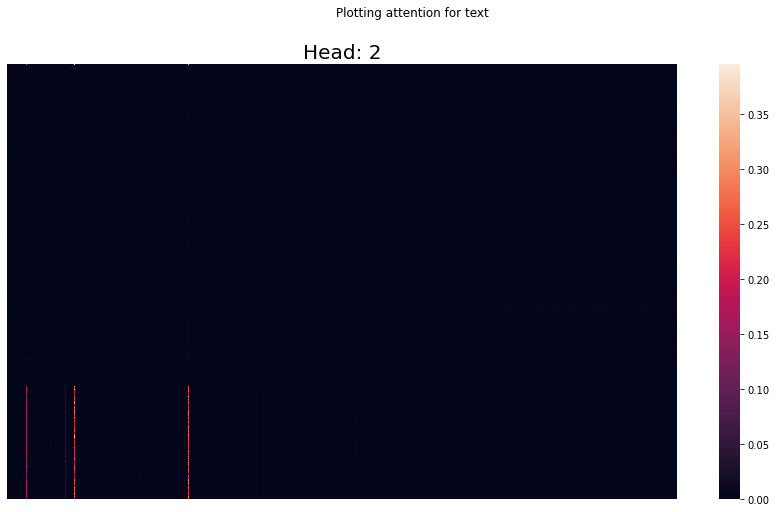

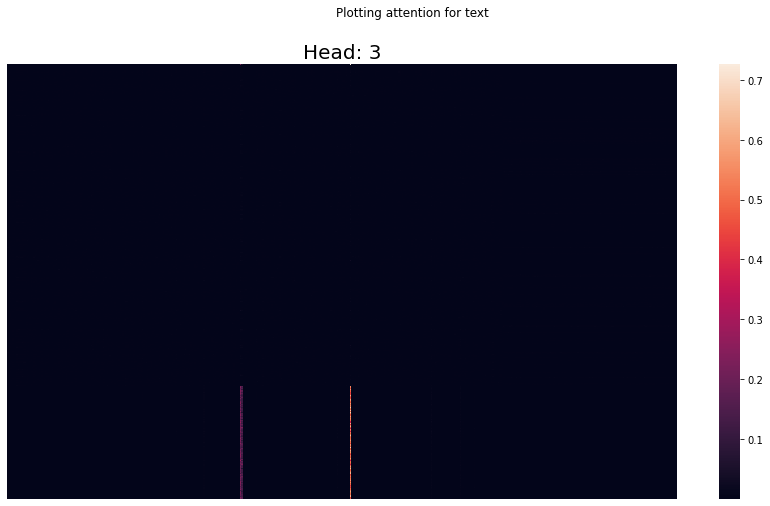

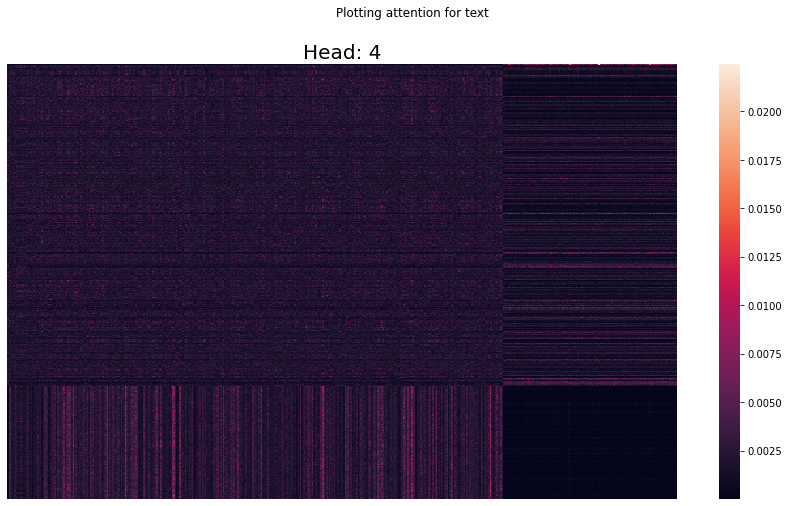

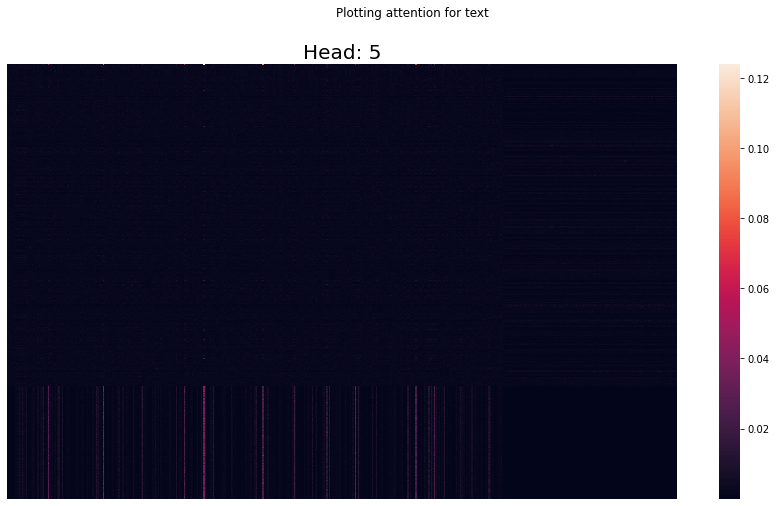

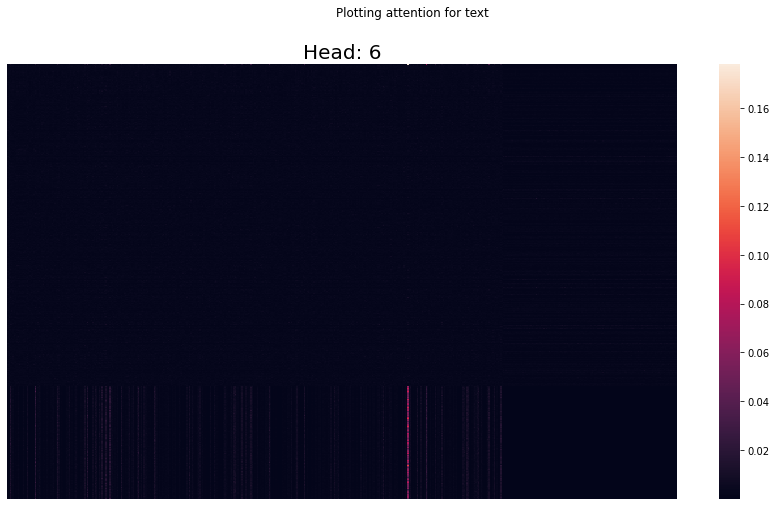

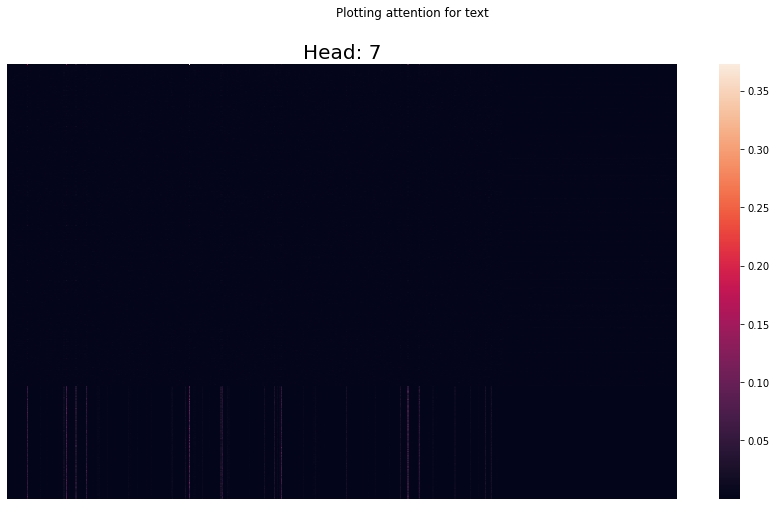

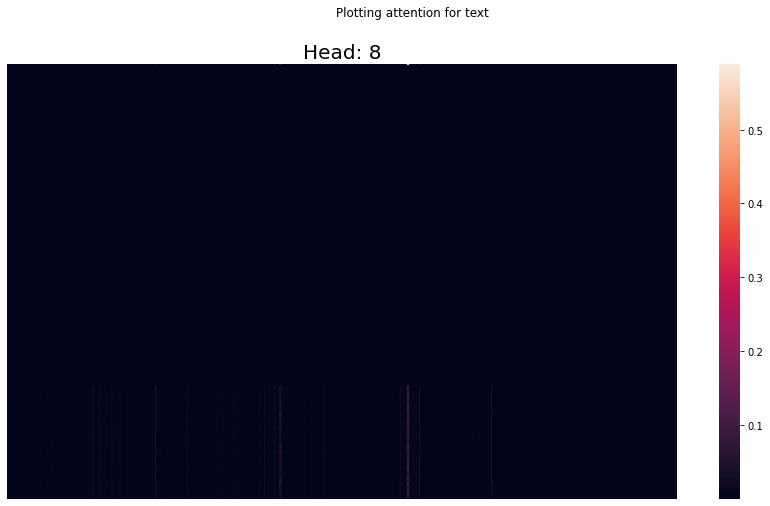

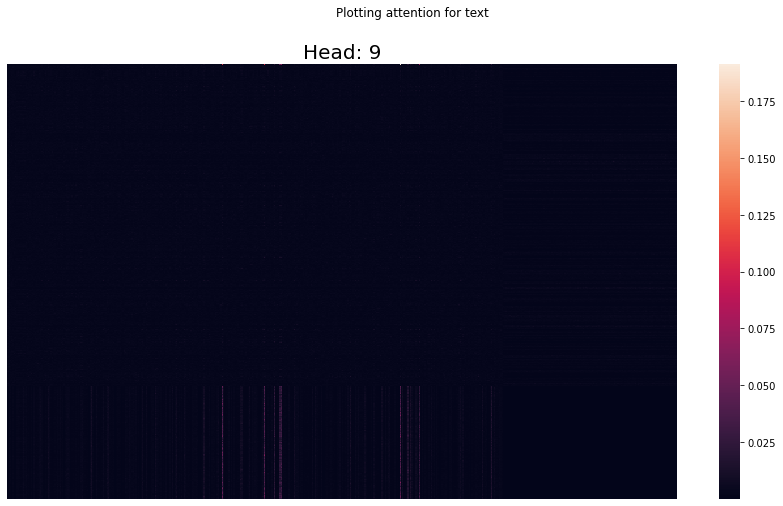

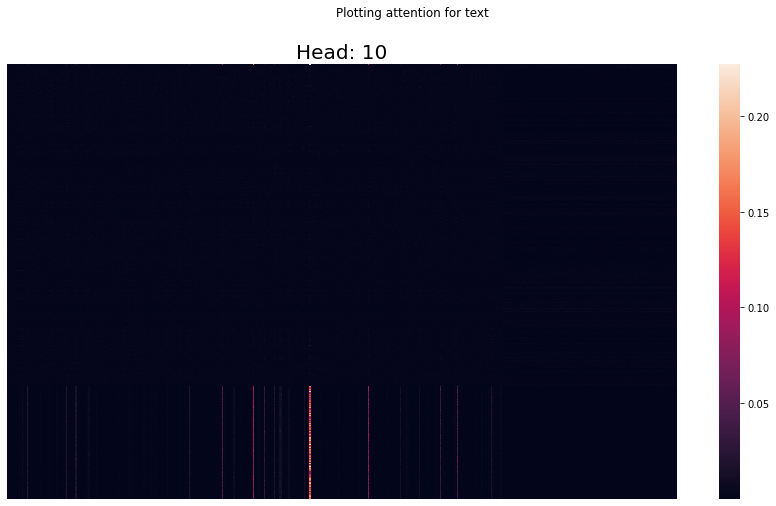

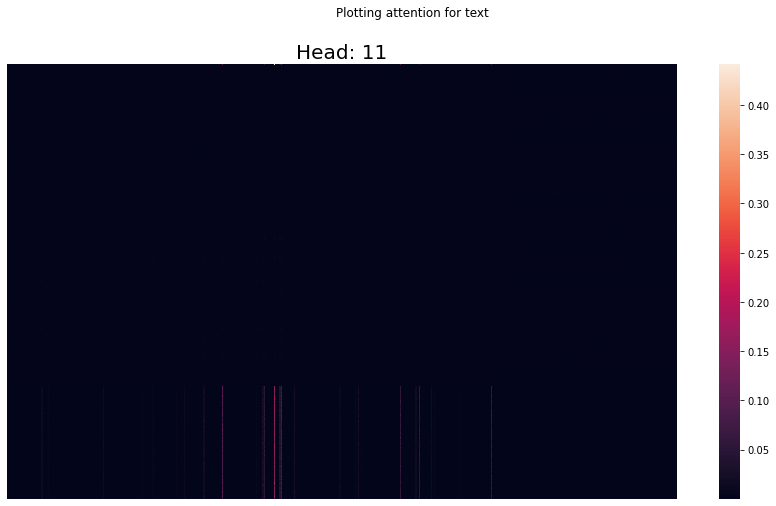

In [29]:
## Plotting the attentions, for text
heads = textual_attn_first_state_prob.shape[0]
for head in range(heads):
    plt.figure(figsize = (15, 8))
    sns.heatmap(textual_attn_first_state_prob[head].detach().numpy(), yticklabels=False, xticklabels=False);
    plt.title(f"Head: {head}", fontsize =20)
    plt.suptitle("Plotting attention for text")